# 2025 Uline Spend Analysis (8 Warehouses)

This notebook:
- Imports the 2025 Uline order history export
- Cleans and standardizes fields (dates, quantities, extended price)
- Produces summary tables and charts to understand spend drivers
- Includes an optional **Ordered By → Warehouse** mapping so results roll up cleanly to the 8 warehouses

> **Input file (uploaded to this chat):** `2025 Uline spend.xlsx`  
> **Expected local directory (your machine):** `C:\Users\dbalan\Desktop\Python\Github\Uline\data`


In [1]:
# --- USER INPUTS ---
INPUT_XLSX = r"C:\Users\dbalan\Desktop\Python\Github\Uline\data\2025 Uline spend.xlsx"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)


In [2]:
# Load the workbook. Uline exports usually include a few header rows, so we load without headers first.
raw = pd.read_excel(INPUT_XLSX, header=None)

# Find the header row that starts with "Date"
header_row_idx = raw.index[raw.iloc[:,0].astype(str).str.strip().eq("Date")][0]

# Re-read using that header row
df = pd.read_excel(INPUT_XLSX, header=header_row_idx)

# Drop fully-empty rows
df = df.dropna(how="all").copy()

# Standardize column names
df.columns = [str(c).strip() for c in df.columns]

# Clean types
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Quantity may contain commas; ensure numeric
df["Qty"] = pd.to_numeric(df["Qty"].astype(str).str.replace(",", "", regex=False), errors="coerce")

# Ext. Price may contain $ and commas
df["Ext. Price"] = (
    df["Ext. Price"].astype(str)
      .str.replace("$", "", regex=False)
      .str.replace(",", "", regex=False)
)
df["Ext. Price"] = pd.to_numeric(df["Ext. Price"], errors="coerce")

# Trim text columns
for c in ["Category", "Model #", "Description", "Ordered By", "PO #"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# Standardize names in 'Ordered By' column
df.loc[df['Ordered By'].str.contains('JANET', case=False, na=False), 'Ordered By'] = 'JANET'
df.loc[df['Ordered By'].str.contains('JOSE' , case=False, na=False), 'Ordered By'] = 'JOSE'
df.loc[df['Ordered By'].str.contains('GERALD', case=False, na=False), 'Ordered By'] = 'GERALD'
df.loc[df['Ordered By'].str.contains('SUSAN', case=False, na=False), 'Ordered By'] = 'SUSAN'
df.loc[df['Ordered By'].str.contains('JONATHAN' , case=False, na=False), 'Ordered By'] = 'JONATHAN'
df.loc[df['Ordered By'].str.contains('DELL', case=False, na=False), 'Ordered By'] = 'DELL'
df.loc[df['Ordered By'].str.contains('GILBERT', case=False, na=False), 'Ordered By'] = 'GILBERT'
df.loc[df['Ordered By'].str.contains('KENNETH', case=False, na=False), 'Ordered By'] = 'JANET'
df.loc[df['Ordered By'].str.contains('DALE', case=False, na=False), 'Ordered By'] = 'DELL'
df.loc[df['Ordered By'].str.contains('TRAVIS', case=False, na=False), 'Ordered By'] = 'TRAVIS'

# Basic derived fields
df["Month"] = df["Date"].dt.to_period("M").dt.to_timestamp()
df["Quarter"] = df["Date"].dt.to_period("Q").astype(str)

df.head()


,Date,Order #,Invoice,PO #,Category,Model #,Description,Qty,Ext. Price,Ordered By,Month,Quarter
0,2025-12-29,45407276,202263519,JANET12292025,Warehouse Equipment / Supplies,H-1598,"LiftAll&reg; Ratchet Tie Downs - E-Track, 2"" x...",6,162.0,JANET,2025-12-01,2025Q4
1,2025-12-29,45407276,202263519,JANET12292025,Strapping,S-512,"Poly Strapping Seals - Open, 1/2"" 1,000/carton",1,36.0,JANET,2025-12-01,2025Q4
2,2025-12-29,45407276,202263519,JANET12292025,Free Offers,S-26269,2026 Bad Kitties&reg; Calendar,1,0.0,JANET,2025-12-01,2025Q4
3,2025-12-22,45168556,202149178,ONT122225ST,Packing List Envelopes,S-209,"""Invoice Enclosed"" Banner Envelopes - Orange, ...",4,116.0,SUSAN,2025-12-01,2025Q4
4,2025-12-22,45168556,202149178,ONT122225ST,Tape,S-445,"Uline Industrial Tape - 2 Mil, 3"" x 110 yds, C...",24,110.4,SUSAN,2025-12-01,2025Q4


In [3]:
# Data quality quick check
summary = pd.DataFrame({
    "rows": [len(df)],
    "min_date": [df["Date"].min()],
    "max_date": [df["Date"].max()],
    "null_date_rows": [df["Date"].isna().sum()],
    "null_price_rows": [df["Ext. Price"].isna().sum()],
    "total_spend": [df["Ext. Price"].sum()],
    "unique_orders": [df["Order #"].nunique() if "Order #" in df.columns else np.nan],
    "unique_invoices": [df["Invoice"].nunique() if "Invoice" in df.columns else np.nan],
    "unique_models": [df["Model #"].nunique() if "Model #" in df.columns else np.nan],
    "unique_ordered_by": [df["Ordered By"].nunique() if "Ordered By" in df.columns else np.nan],
    "unique_categories": [df["Category"].nunique() if "Category" in df.columns else np.nan],
})
summary


,rows,min_date,max_date,null_date_rows,null_price_rows,total_spend,unique_orders,unique_invoices,unique_models,unique_ordered_by,unique_categories
0,1502,2025-01-03,2025-12-29,0,0,242986.57,178,186,500,8,35


## Optional: Map `Ordered By` to your 8 warehouse sites

The export does not explicitly include a warehouse/site column.  
If each person primarily orders for one site, you can roll up spend cleanly by adding a mapping below.

- If you **leave the mapping empty**, the notebook will analyze by `Ordered By`.
- If you **fill in the mapping**, you’ll get charts by `Warehouse` instead.



In [4]:
# --- OPTIONAL MAPPING ---
# Normalize Ordered By
df["Ordered By"] = (
    df["Ordered By"]
    .astype(str)
    .str.strip()
    .str.upper()
    .str.replace("’", "'", regex=False)
    .str.replace("'", "", regex=False)
    .str.lstrip("#")
)

ordered_by_to_warehouse = {
    "JANET": "Charlotte",
    "SUSAN": "Ontario",
    "JOSE": "Orlando",
    "DELL": "Flowood",
    "GERALD": "Phoenix",
    "GILBERT": "Oklahoma City",
    "TRAVIS": "Atlanta",
    "RICARDO": "El Paso",
    "JONATHAN": "Atlanta",
}

df["Warehouse"] = df["Ordered By"].map(ordered_by_to_warehouse)



# Audit unmapped values
print("Unmapped Ordered By values:")
print(df.loc[df["Warehouse"].isna(), "Ordered By"].unique())
df.head(20)


Unmapped Ordered By values:
[]


,Date,Order #,Invoice,PO #,Category,Model #,Description,Qty,Ext. Price,Ordered By,Month,Quarter,Warehouse
0,2025-12-29,45407276,202263519,JANET12292025,Warehouse Equipment / Supplies,H-1598,"LiftAll&reg; Ratchet Tie Downs - E-Track, 2"" x...",6,162.00,JANET,2025-12-01,2025Q4,Charlotte
1,2025-12-29,45407276,202263519,JANET12292025,Strapping,S-512,"Poly Strapping Seals - Open, 1/2"" 1,000/carton",1,36.00,JANET,2025-12-01,2025Q4,Charlotte
2,2025-12-29,45407276,202263519,JANET12292025,Free Offers,S-26269,2026 Bad Kitties&reg; Calendar,1,0.00,JANET,2025-12-01,2025Q4,Charlotte
3,2025-12-22,45168556,202149178,ONT122225ST,Packing List Envelopes,S-209,"""Invoice Enclosed"" Banner Envelopes - Orange, ...",4,116.00,SUSAN,2025-12-01,2025Q4,Ontario
4,2025-12-22,45168556,202149178,ONT122225ST,Tape,S-445,"Uline Industrial Tape - 2 Mil, 3"" x 110 yds, C...",24,110.40,SUSAN,2025-12-01,2025Q4,Ontario
5,2025-12-22,45168556,202149178,ONT122225ST,Stretch Wrap,S-12988S,Uline Machine Length Stretch Film Skid Lot - O...,32,2240.00,SUSAN,2025-12-01,2025Q4,Ontario
6,2025-12-22,45168556,202149178,ONT122225ST,Envelopes and Mailers,S-7805,"Self-Seal Envelopes - Kraft, 9 x 12"" 100/case",2,42.00,SUSAN,2025-12-01,2025Q4,Ontario
7,2025-12-22,45168556,202149178,ONT122225ST,Strapping,S-1081S,"Steel Strapping Skid Lot - Standard Grade, 1/2...",12,1608.00,SUSAN,2025-12-01,2025Q4,Ontario
8,2025-12-22,45168556,202149178,ONT122225ST,Tape,H-596,"Uline Industrial Side Loader Tape Dispenser - 3""",1,0.00,SUSAN,2025-12-01,2025Q4,Ontario
9,2025-12-22,45168556,202149178,ONT122225ST,Warehouse Equipment / Supplies,H-2019,Manual Staple Gun,1,35.00,SUSAN,2025-12-01,2025Q4,Ontario


## Executive KPIs

In [5]:
kpis = {
    "Total spend": df["Ext. Price"].sum(),
    "Total lines": len(df),
    "Total quantity": df["Qty"].sum(),
    "Unique orders": df["Order #"].nunique(),
    "Unique invoices": df["Invoice"].nunique(),
    "Avg $ per order": df.groupby("Order #")["Ext. Price"].sum().mean(),
    "Median $ per order": df.groupby("Order #")["Ext. Price"].sum().median(),
    "Avg line $": df["Ext. Price"].mean(),
}

pd.Series(kpis).to_frame("Value")


,Value
Total spend,242986.570000
Total lines,1502.000000
Total quantity,39585.000000
Unique orders,178.000000
Unique invoices,186.000000
Avg $ per order,1365.093090
Median $ per order,1028.500000
Avg line $,161.775346


## Spend over time (monthly trend)

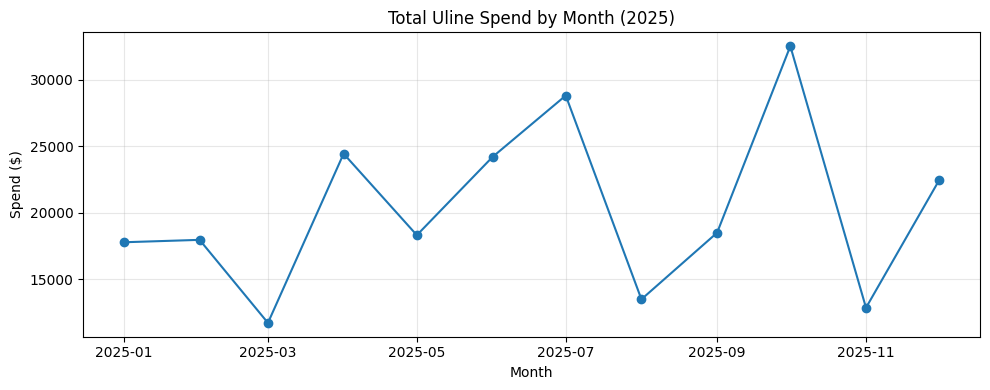

,Month,Ext. Price
0,2025-01-01,17775.83
1,2025-02-01,17956.68
2,2025-03-01,11714.49
3,2025-04-01,24433.88
4,2025-05-01,18310.05
5,2025-06-01,24187.09
6,2025-07-01,28805.74
7,2025-08-01,13486.75
8,2025-09-01,18492.84
9,2025-10-01,32517.42


In [6]:
monthly = df.groupby("Month", as_index=False)["Ext. Price"].sum().sort_values("Month")

plt.figure(figsize=(10,4))
plt.plot(monthly["Month"], monthly["Ext. Price"], marker="o")
plt.title("Total Uline Spend by Month (2025)")
plt.xlabel("Month")
plt.ylabel("Spend ($)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

monthly


## Spend by warehouse / requestor (Pareto)

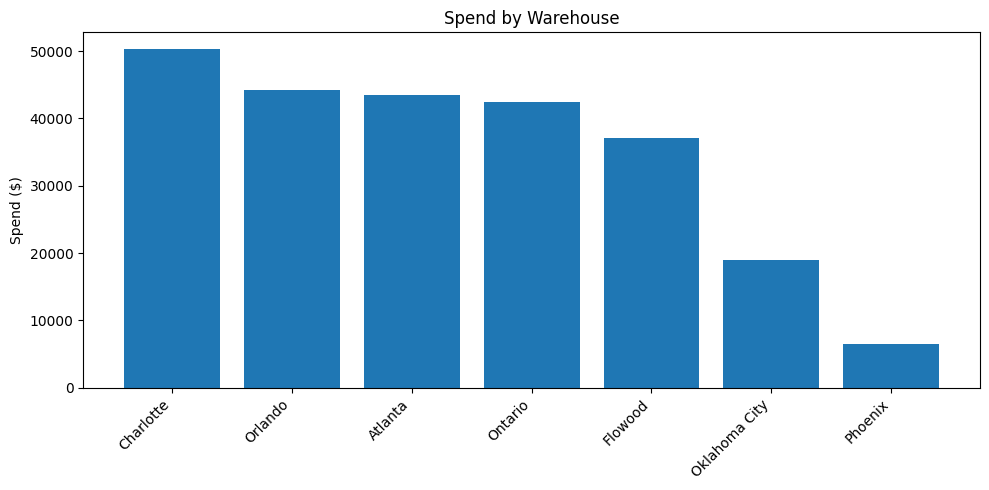

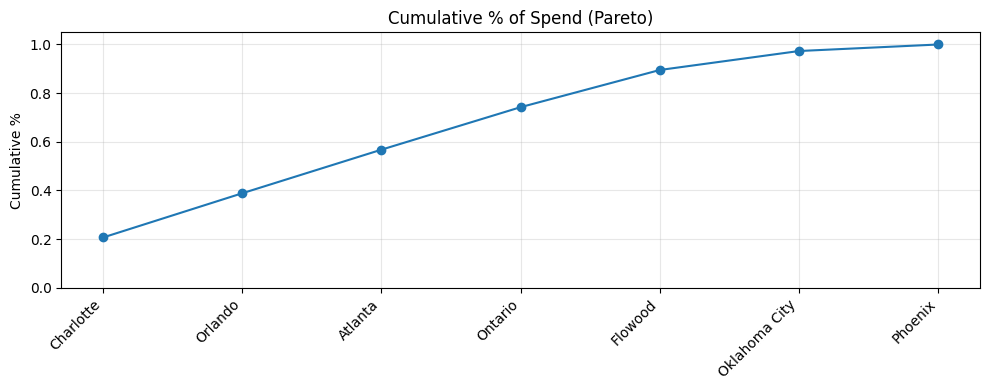

,Warehouse,Ext. Price,CumSpend,CumPct
1,Charlotte,50259.50,50259.50,0.206841
5,Orlando,44165.03,94424.53,0.388600
0,Atlanta,43533.24,137957.77,0.567759
4,Ontario,42446.55,180404.32,0.742446
2,Flowood,37128.45,217532.77,0.895246
3,Oklahoma City,18941.70,236474.47,0.973200
6,Phoenix,6512.10,242986.57,1.000000


In [7]:
by_wh = (
    df.groupby("Warehouse", as_index=False)["Ext. Price"]
      .sum()
      .sort_values("Ext. Price", ascending=False)
)
by_wh["CumSpend"] = by_wh["Ext. Price"].cumsum()
by_wh["CumPct"] = by_wh["CumSpend"] / by_wh["Ext. Price"].sum()

plt.figure(figsize=(10,5))
plt.bar(by_wh["Warehouse"], by_wh["Ext. Price"])
plt.xticks(rotation=45, ha="right")
plt.title("Spend by Warehouse")
plt.ylabel("Spend ($)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(by_wh["Warehouse"], by_wh["CumPct"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Cumulative % of Spend (Pareto)")
plt.ylabel("Cumulative %")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

by_wh.head(30)


## Heatmap: spend by month × warehouse/requestor

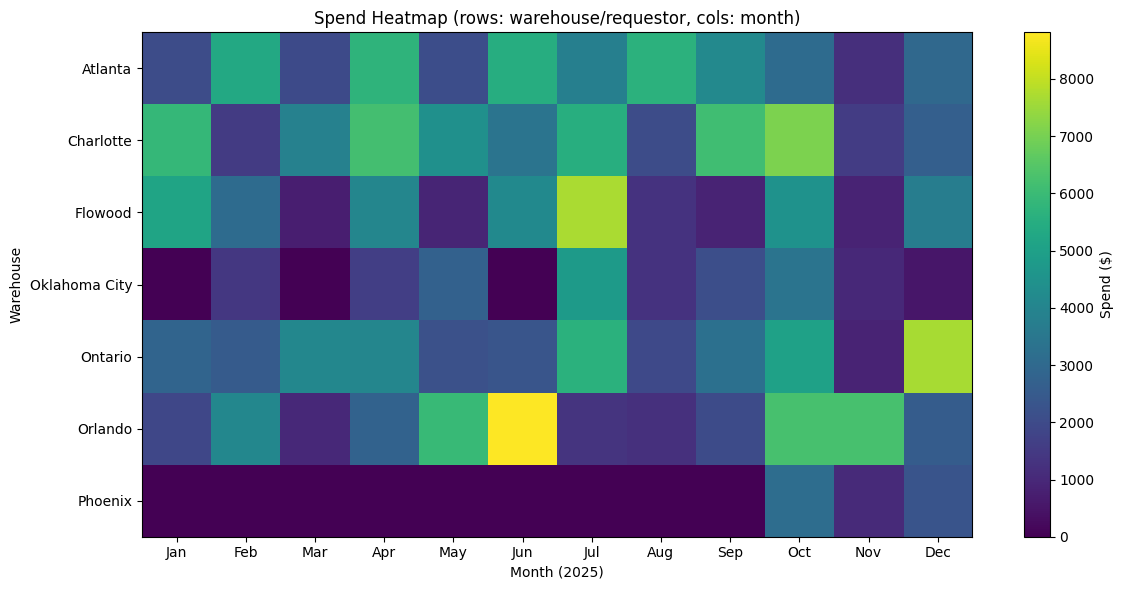

Month,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01,2025-11-01,2025-12-01
Warehouse,,,,,,,,,,,,
Atlanta,2035.70,5325.79,1997.20,5721.60,2092.30,5504.60,3799.90,5665.40,4140.00,3086.70,1174.50,2989.55
Charlotte,5883.75,1520.00,3890.75,6171.50,4432.30,3375.40,5528.60,2054.40,6098.90,7075.30,1576.40,2652.20
Flowood,5142.99,3067.50,747.00,4060.99,924.50,4182.75,7702.25,1297.25,863.25,4507.73,891.00,3741.24
Oklahoma City,0.00,1432.64,0.00,1645.80,2733.80,0.00,4795.00,1293.70,2120.40,3376.00,1011.36,533.00
Ontario,2849.15,2537.00,4067.55,4061.20,2177.15,2309.10,5641.00,1940.50,3257.50,5060.80,874.00,7671.60
Orlando,1864.24,4073.75,1011.99,2772.79,5950.00,8815.24,1338.99,1235.50,2012.79,6244.19,6266.70,2578.85
Phoenix,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3166.70,1059.70,2285.70


In [8]:
pivot = df.pivot_table(
    index="Warehouse",
    columns="Month",
    values="Ext. Price",
    aggfunc="sum",
    fill_value=0
)

plt.figure(figsize=(12,6))
plt.imshow(pivot.values, aspect="auto")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), [d.strftime("%b") for d in pivot.columns], rotation=0)
plt.title("Spend Heatmap (rows: warehouse/requestor, cols: month)")
plt.xlabel("Month (2025)")
plt.ylabel("Warehouse")
plt.colorbar(label="Spend ($)")
plt.tight_layout()
plt.show()

pivot


## Category analysis (top categories + monthly mix)

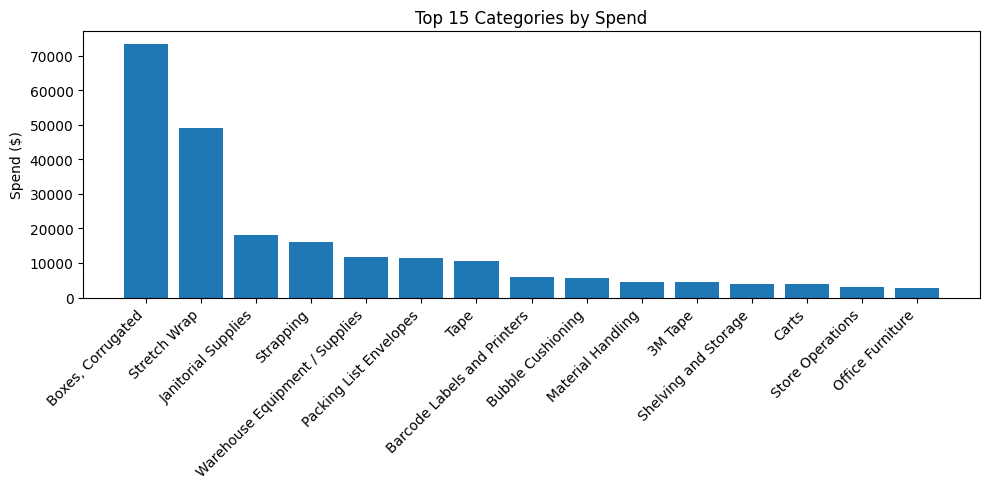

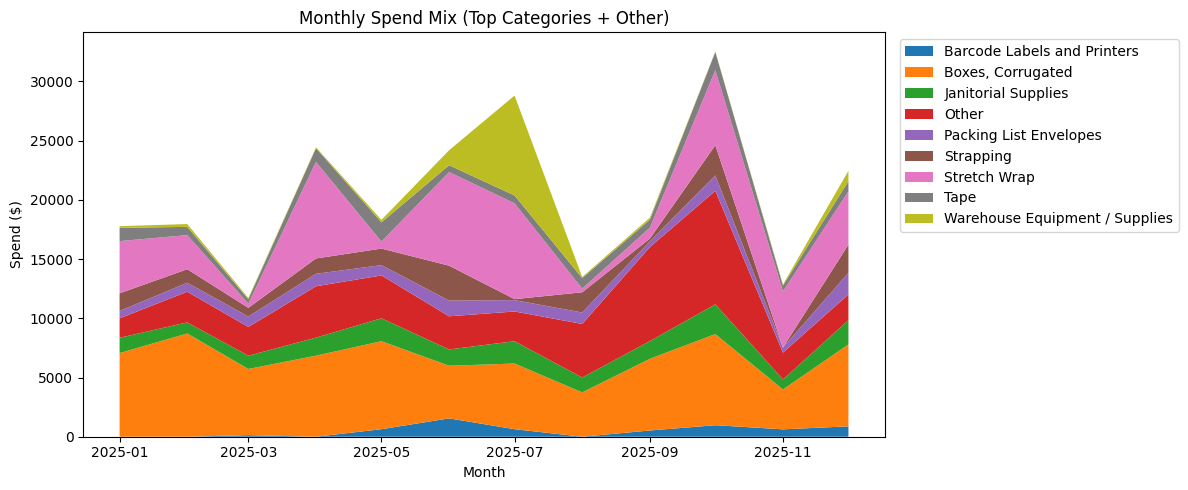

,Category,Ext. Price
4,"Boxes, Corrugated",73403.05
30,Stretch Wrap,49172.40
15,Janitorial Supplies,18218.90
29,Strapping,15957.00
32,Warehouse Equipment / Supplies,11713.75
22,Packing List Envelopes,11481.00
31,Tape,10688.42
2,Barcode Labels and Printers,5950.00
5,Bubble Cushioning,5712.00
18,Material Handling,4596.00


In [9]:
top_cat = (
    df.groupby("Category", as_index=False)["Ext. Price"]
      .sum()
      .sort_values("Ext. Price", ascending=False)
)

plt.figure(figsize=(10,5))
plt.bar(top_cat["Category"].head(15), top_cat["Ext. Price"].head(15))
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Categories by Spend")
plt.ylabel("Spend ($)")
plt.tight_layout()
plt.show()

# Monthly category mix (top 8 categories + 'Other')
top8 = top_cat["Category"].head(8).tolist()
df["Category_top"] = np.where(df["Category"].isin(top8), df["Category"], "Other")
mix = df.pivot_table(index="Month", columns="Category_top", values="Ext. Price", aggfunc="sum", fill_value=0).sort_index()

plt.figure(figsize=(12,5))
# Stacked area
plt.stackplot(mix.index, mix.T.values, labels=mix.columns)
plt.title("Monthly Spend Mix (Top Categories + Other)")
plt.xlabel("Month")
plt.ylabel("Spend ($)")
plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
plt.tight_layout()
plt.show()

top_cat.head(25)


## Item / SKU analysis (Model #)

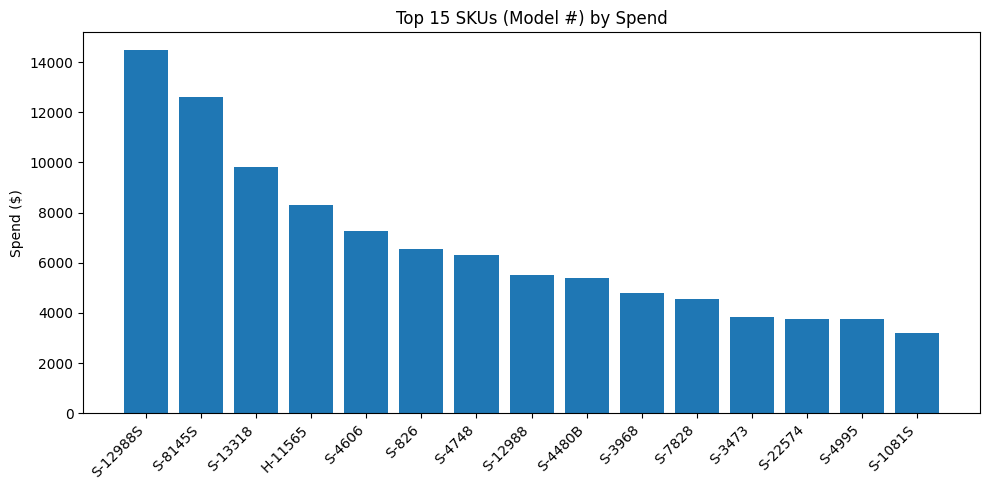

,Model #,Description,lines,orders,total_spend,total_qty
138,S-11683,Oil-Dri&reg; Premium Bag - 35 lb,29,29,2613.25,139
402,S-4125,"12 x 12 x 12"" Corrugated Boxes 25/bundle",31,29,2479.75,2275
414,S-423,"Uline Industrial Tape - 2 Mil, 2"" x 110 yds, C...",29,27,2958.12,1500
468,S-7127,"Uline Deluxe Multi-Fold Towels 4,000 sheets/case",27,27,1672.00,44
26,H-150,"Uline Industrial Side Loader Tape Dispenser - 2""",28,26,0.00,26
244,S-209,"""Invoice Enclosed"" Banner Envelopes - Orange, ...",22,22,2552.00,88
485,S-7815,American Flag Packing List Envelopes - 4 1/2 x...,23,21,1530.00,51
95,H-596,"Uline Industrial Side Loader Tape Dispenser - 3""",18,18,20.00,18
493,S-826,"Steel Strapping - Standard Grade, 3/4"" x .020""...",19,17,6544.00,28
434,S-4748,"40 x 8 x 8"" Long Corrugated Boxes 25/bundle",17,17,6306.75,2075


In [10]:
# Top SKUs by spend
top_sku = (
    df.groupby(["Model #", "Description"], as_index=False)["Ext. Price"]
      .sum()
      .sort_values("Ext. Price", ascending=False)
)

plt.figure(figsize=(10,5))
plt.bar(top_sku["Model #"].head(15), top_sku["Ext. Price"].head(15))
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 SKUs (Model #) by Spend")
plt.ylabel("Spend ($)")
plt.tight_layout()
plt.show()

# Repeat-buy SKUs (count of distinct orders)
repeat = (
    df.groupby(["Model #", "Description"])
      .agg(lines=("Ext. Price", "size"),
           orders=("Order #", "nunique"),
           total_spend=("Ext. Price", "sum"),
           total_qty=("Qty", "sum"))
      .reset_index()
      .sort_values(["orders", "total_spend"], ascending=False)
)

repeat.head(30)


## Order size distribution (spot big orders)

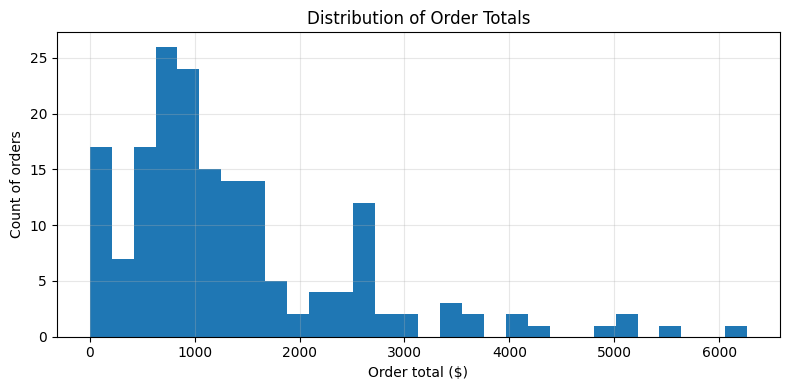

,Order #,Warehouse,Ext. Price
153,42822046,Orlando,6266.70
59,34325271,Charlotte,5526.50
163,43697080,Charlotte,5110.10
112,38840320,Charlotte,5015.60
11,29039249,Charlotte,4885.75
86,36909727,Flowood,4195.00
176,45168556,Ontario,4151.40
63,34626904,Oklahoma City,4150.00
56,33958988,Orlando,3619.25
41,32561014,Ontario,3587.00


In [11]:
order_totals = df.groupby(["Order #", "Warehouse"], as_index=False)["Ext. Price"].sum()
order_totals = order_totals.sort_values("Ext. Price", ascending=False)

plt.figure(figsize=(8,4))
plt.hist(order_totals["Ext. Price"].dropna(), bins=30)
plt.title("Distribution of Order Totals")
plt.xlabel("Order total ($)")
plt.ylabel("Count of orders")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

order_totals.head(20)


## Savings opportunity flags (rule-based)

These are **starting points**—they highlight where to investigate:
- **Free offers** / zero-dollar lines: validate if they’re useful or avoid clutter
- **High-frequency SKUs**: candidate for standardization, min/max, bulk buying, or vendor-managed inventory
- **“Long tail” suppliers/categories**: consolidate to fewer SKUs or brands
- **Outlier orders**: ensure they were planned/approved (one-time equipment vs. drift)


In [12]:
# Free / $0 lines
free_lines = df[df["Ext. Price"].fillna(0) <= 0].copy()

# High-frequency SKUs
hi_freq = (
    df.groupby(["Model #", "Description"])
      .agg(lines=("Ext. Price", "size"),
           orders=("Order #", "nunique"),
           total_spend=("Ext. Price", "sum"),
           avg_line_spend=("Ext. Price", "mean"))
      .reset_index()
      .sort_values(["lines", "total_spend"], ascending=False)
)

# Unique models per category
models_per_cat = (
    df.groupby('Category')['Model #'].nunique()
        .reset_index().rename(columns={'Model #': 'unique_models'})
        .sort_values('unique_models', ascending=False)
)


# Outlier orders (top 3%)
threshold = order_totals["Ext. Price"].quantile(0.97)
outliers = order_totals[order_totals["Ext. Price"] >= threshold]

print(f"Free/$0 lines: {len(free_lines)}")
display(free_lines.head(20))

print(f"Hi freq lines: {len(hi_freq)}")
print("Top 5 high-frequency SKUs:")
for _, row in hi_freq.head(5).iterrows():
    print(f"- {row['Model #']}: {row['Description']} ({row['lines']} lines)")
display(hi_freq.head(25))

print(f"Top 3% order threshold: ${threshold:,.2f} (orders >= threshold: {len(outliers)})")
print(f"Outliers: {len(outliers)}")
display(outliers.head(25))

print(f"Unique models per category: {len(models_per_cat)}")
display(models_per_cat.head(25))


Free/$0 lines: 228


,Date,Order #,Invoice,PO #,Category,Model #,Description,Qty,Ext. Price,Ordered By,Month,Quarter,Warehouse,Category_top
2,2025-12-29,45407276,202263519,JANET12292025,Free Offers,S-26269,2026 Bad Kitties&reg; Calendar,1,0.0,JANET,2025-12-01,2025Q4,Charlotte,Other
8,2025-12-22,45168556,202149178,ONT122225ST,Tape,H-596,"Uline Industrial Side Loader Tape Dispenser - 3""",1,0.0,SUSAN,2025-12-01,2025Q4,Ontario,Tape
10,2025-12-22,45168556,202149178,ONT122225ST,Free Offers,H-12115,Emergency Crank Radio,1,0.0,SUSAN,2025-12-01,2025Q4,Ontario,Other
25,2025-12-20,45077845,202133965,WHS600JOSE',Free Offers,H-10898,Air Fryer,1,0.0,JOSE,2025-12-01,2025Q4,Orlando,Other
36,2025-12-19,45043816,202093655,GERALD,Free Offers,S-25532,Classic Holiday Nuts Collection,1,0.0,GERALD,2025-12-01,2025Q4,Phoenix,Other
41,2025-12-18,44826380,202033438,GILBERT,Tape,H-150,"Uline Industrial Side Loader Tape Dispenser - 2""",1,0.0,GILBERT,2025-12-01,2025Q4,Oklahoma City,Tape
44,2025-12-18,44826380,202033438,GILBERT,Free Offers,S-25077DAL-L,"NFL Henley - Dallas Cowboys, Large",1,0.0,GILBERT,2025-12-01,2025Q4,Oklahoma City,Other
46,2025-12-17,44774823,201977702,JONATHAN,Tape,H-150,"Uline Industrial Side Loader Tape Dispenser - 2""",1,0.0,JONATHAN,2025-12-01,2025Q4,Atlanta,Tape
60,2025-12-17,44774823,201977702,JONATHAN,Free Offers,S-25692DAL-X,"Ladies' NFL Crewneck - Dallas Cowboys, XL",1,0.0,JONATHAN,2025-12-01,2025Q4,Atlanta,Other
63,2025-12-16,44586736,201906707,JANET12162025,Free Offers,S-26130,Blackstone Seasoning Set,1,0.0,JANET,2025-12-01,2025Q4,Charlotte,Other


Hi freq lines: 500
Top 5 high-frequency SKUs:
- S-4125: 12 x 12 x 12" Corrugated Boxes 25/bundle (31 lines)
- S-423: Uline Industrial Tape - 2 Mil, 2" x 110 yds, Clear 36 rolls/case (29 lines)
- S-11683: Oil-Dri&reg; Premium Bag - 35 lb (29 lines)
- H-150: Uline Industrial Side Loader Tape Dispenser - 2" (28 lines)
- S-7127: Uline Deluxe Multi-Fold Towels 4,000 sheets/case (27 lines)


,Model #,Description,lines,orders,total_spend,avg_line_spend
402,S-4125,"12 x 12 x 12"" Corrugated Boxes 25/bundle",31,29,2479.75,79.991935
414,S-423,"Uline Industrial Tape - 2 Mil, 2"" x 110 yds, C...",29,27,2958.12,102.004138
138,S-11683,Oil-Dri&reg; Premium Bag - 35 lb,29,29,2613.25,90.112069
26,H-150,"Uline Industrial Side Loader Tape Dispenser - 2""",28,26,0.00,0.000000
468,S-7127,"Uline Deluxe Multi-Fold Towels 4,000 sheets/case",27,27,1672.00,61.925926
485,S-7815,American Flag Packing List Envelopes - 4 1/2 x...,23,21,1530.00,66.521739
244,S-209,"""Invoice Enclosed"" Banner Envelopes - Orange, ...",22,22,2552.00,116.000000
493,S-826,"Steel Strapping - Standard Grade, 3/4"" x .020""...",19,17,6544.00,344.421053
95,H-596,"Uline Industrial Side Loader Tape Dispenser - 3""",18,18,20.00,1.111111
434,S-4748,"40 x 8 x 8"" Long Corrugated Boxes 25/bundle",17,17,6306.75,370.985294


Top 3% order threshold: $4,181.48 (orders >= threshold: 6)
Outliers: 6


,Order #,Warehouse,Ext. Price
153,42822046,Orlando,6266.70
59,34325271,Charlotte,5526.50
163,43697080,Charlotte,5110.10
112,38840320,Charlotte,5015.60
11,29039249,Charlotte,4885.75
86,36909727,Flowood,4195.00


Unique models per category: 35


,Category,unique_models
13,Free Offers,99
4,"Boxes, Corrugated",69
15,Janitorial Supplies,68
32,Warehouse Equipment / Supplies,28
11,Facilities Maintenance,24
17,Markers / Stencils,18
16,Labels,18
29,Strapping,17
14,Gloves,16
30,Stretch Wrap,16


## Export cleaned data + summaries (optional)

Run this if you want a cleaned dataset and key summary tables saved to your output folder.

In [15]:
import os

# Set this when running locally 
OUTPUT_DIR = r"C:\Users\dbalan\Desktop\Python\Github\Uline\data\exports"
os.makedirs(OUTPUT_DIR, exist_ok=True)

df.to_csv(os.path.join(OUTPUT_DIR, "uline_2025_cleaned_lines.csv"), index=False)
monthly.to_csv(os.path.join(OUTPUT_DIR, "uline_2025_monthly_spend.csv"), index=False)
by_wh.to_csv(os.path.join(OUTPUT_DIR, "uline_2025_by_warehouse.csv"), index=False)
top_cat.to_csv(os.path.join(OUTPUT_DIR, "uline_2025_by_category.csv"), index=False)
top_sku.head(200).to_csv(os.path.join(OUTPUT_DIR, "uline_2025_top_skus.csv"), index=False)
free_lines.to_csv(os.path.join(OUTPUT_DIR, "uline_free_lines.csv"), index=False)
hi_freq.to_csv(os.path.join(OUTPUT_DIR, "uline_hi_frequency_items.csv"), index=False)
models_per_cat.to_csv(os.path.join(OUTPUT_DIR, "uline_unique_models_per_category.csv"), index=False)

OUTPUT_DIR


'C:\\Users\\dbalan\\Desktop\\Python\\Github\\Uline\\data\\exports'